In [119]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cloudmesh.common.StopWatch import StopWatch
from tensorflow import keras
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_squared_error
import pathlib
from pathlib import Path

In [120]:
cryptoName = input('Please enter the name of the crypto to predict.\nExamples include "EOS-USD", "DOGE-USD",\n"ETH-USD", and "BTC-USD" without double quotes')
print(cryptoName+' selected')


EOS-USD selected


In [121]:
StopWatch.start("Overall time")

# Creating desktop path to save figures to the desktop
desktop = pathlib.Path.home() / 'Desktop'
desktop2 = str(Path(desktop))
fullpath = desktop2 + "\\"+cryptoName+"-prediction-model.png"
fullpath2 = desktop2 + "\\"+cryptoName+"-prediction-model-zoomed.png"
fullpath3 = desktop2 + "\\"+cryptoName+"-price.png"
fullpath4 = desktop2 + "\\"+cryptoName+"-training-loss.png"
pdfpath = desktop2 + "\\"+cryptoName+"-prediction-model.pdf"
pdfpath2 = desktop2 + "\\"+cryptoName+"-prediction-model-zoomed.pdf"
pdfpath3 = desktop2 + "\\"+cryptoName+"-price.pdf"
pdfpath4 = desktop2 + "\\"+cryptoName+"-training-loss.pdf"


register_matplotlib_converters()

In [122]:
ticker = yf.Ticker(cryptoName)
data = ticker.history(period = "max", interval = "1d")
#print(data)
# Sort the dataframe according to the date
data.sort_values('Date', inplace=True, ascending=True)

# Print the dataframe top
data.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-11-09,1.13307,1.20771,1.13254,1.18080,24725800,0,0
2017-11-10,1.18214,1.18214,0.99488,1.03065,23024200,0,0
2017-11-11,1.02906,1.18155,1.01155,1.16498,27539300,0,0
2017-11-12,1.15967,1.17923,1.03654,1.09397,29229800,0,0
2017-11-13,1.09447,1.18850,1.08344,1.17888,20848600,0,0


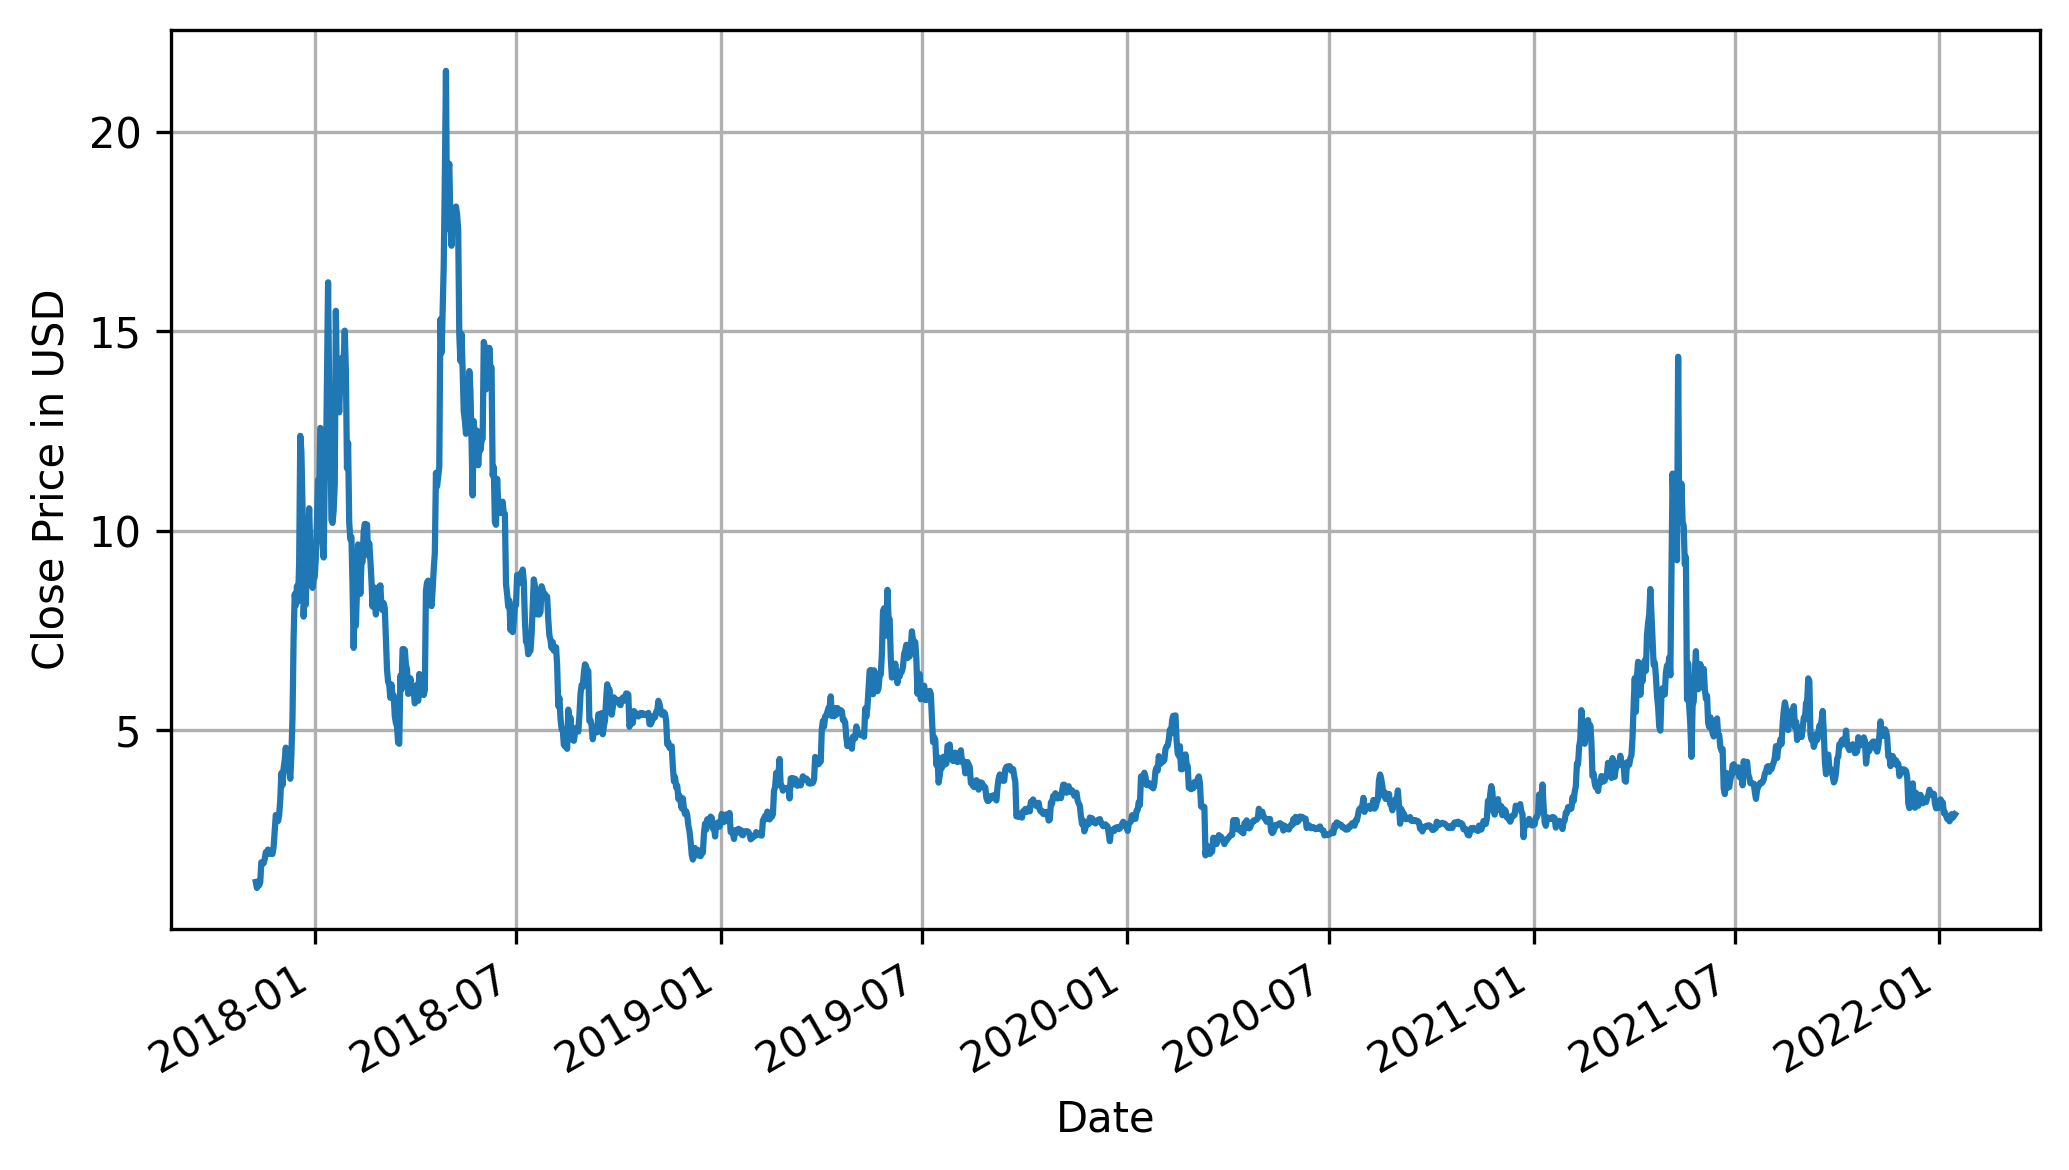

In [123]:
# Visualization of data. Plotting the price close.
plt.figure(num=None, figsize=(7, 4), dpi=300, facecolor='w', edgecolor='k')
data['Close'].plot()
plt.tight_layout()
plt.grid()
plt.ylabel('Close Price in USD')
plt.xlabel('Date')
plt.tight_layout()
#plt.savefig(fullpath3, dpi=300, facecolor="#FFFFFF")
plt.savefig(pdfpath3, dpi=300)
plt.show()

In [104]:
print(data.index[0])
firstDate = data.index[0]
firstDateFormatted = pd.to_datetime(data.index[0], utc=False)
print(firstDateFormatted)
date_time_obj = firstDateFormatted.to_pydatetime()
trueFirstDate = date_time_obj.strftime('%m/%d/%Y')
print(trueFirstDate)


2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017


In [105]:
print(data.head())


                  Open        High         Low       Close      Volume  \
Date                                                                     
2017-11-09  308.644989  329.451996  307.056000  320.884003   893249984   
2017-11-10  320.670990  324.717987  294.541992  299.252991   885985984   
2017-11-11  298.585999  319.453003  298.191986  314.681000   842300992   
2017-11-12  314.690002  319.153015  298.513000  307.907990  1613479936   
2017-11-13  307.024994  328.415009  307.024994  316.716003  1041889984   

            Dividends  Stock Splits  
Date                                 
2017-11-09          0             0  
2017-11-10          0             0  
2017-11-11          0             0  
2017-11-12          0             0  
2017-11-13          0             0  


In [106]:
# Get Close data
df = data[['Close']].copy()
# Split data into train and test
train, test = df.iloc[0:-200], df.iloc[-200:len(df)]

print(len(train), len(test))

1328 200


In [107]:
train_max = train.max()
train_min = train.min()

# Normalize the dataframes
train = (train - train_min)/(train_max - train_min)
test = (test - train_min)/(train_max - train_min)

In [108]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


time_steps = 10

X_train, y_train = create_dataset(train, train.Close, time_steps)
X_test, y_test = create_dataset(test, test.Close, time_steps)

In [109]:
StopWatch.start("Training time")

model = keras.Sequential()
model.add(keras.layers.LSTM(250, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    shuffle=False
)

StopWatch.stop("Training time")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 250)               252000    
                                                                 
 dropout_4 (Dropout)         (None, 250)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 251       
                                                                 
Total params: 252,251
Trainable params: 252,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
42/42 [==============================] - 3s 19ms/step - loss: 0.0541
Epoch 2/50
42/42 [==============================] - 1s 17ms/step - loss: 0.0505
Epoch 3/50
42/42 [==============================] - 1s 17ms/step - loss: 0.0699
Epoch 4/50
42/42 [==============================] - 1s 17ms/step - loss:

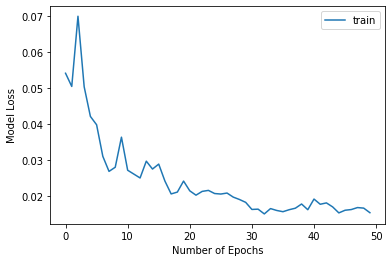

In [110]:
# Plotting the loss
plt.plot(history.history['loss'], label='train')
plt.legend();
plt.ylabel('Model Loss')
plt.xlabel('Number of Epochs')
plt.savefig(pdfpath4, dpi=300)
plt.show()

In [111]:
StopWatch.start("Prediction time")

y_pred = model.predict(X_test)

StopWatch.stop("Prediction time")

# Rescale the data back to the original scale
y_test = y_test*(train_max[0] - train_min[0]) + train_min[0]
y_pred = y_pred*(train_max[0] - train_min[0]) + train_min[0]
y_train = y_train*(train_max[0] - train_min[0]) + train_min[0]


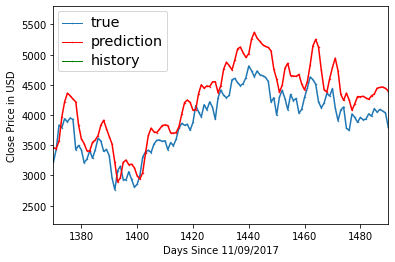

In [118]:
# Plotting the results
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test.flatten(), marker='.', markersize=1, label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred.flatten(), 'r', marker='.', markersize=1, label="prediction")
plt.plot(np.arange(0, len(y_train)), y_train.flatten(), 'g', marker='.', markersize=1, label="history")
plt.ylabel('Close Price in USD')
plt.xlabel('Days Since '+trueFirstDate)
leg = plt.legend()
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
plt.setp(leg_lines, linewidth=1)
plt.setp(leg_texts, fontsize='x-large')
plt.savefig(pdfpath, dpi=300)
#doge plt.axis([1350, 1450, 0.14, 0.35])
#btc plt.axis([2490, 2650, 34000, 73000])
#eth plt.axis([1370, 1490, 2200, 5800])
plt.axis([1370, 1490, 2200, 5800])
plt.savefig(pdfpath2, dpi=300)
plt.show()


In [55]:
print(y_test.shape)
print(y_pred.shape)


(190,)
(190, 1)


In [239]:
## Outputs error in United States Dollars
mean_squared_error(y_test, y_pred)

## Create a table of the error against the number of epochs

10953851.053762214

In [240]:
StopWatch.stop("Overall time")
StopWatch.benchmark()


+------------------+--------------------------------------------------------------------------------+
| Attribute        | Value                                                                          |
|------------------+--------------------------------------------------------------------------------|
| cpu              |                                                                                |
| cpu_cores        | 6                                                                              |
| cpu_count        | 12                                                                             |
| cpu_threads      | 12                                                                             |
| frequency        | scpufreq(current=3600.0, min=0.0, max=3600.0)                                  |
| mem.available    | 7.4 GiB                                                                        |
| mem.free         | 7.4 GiB                                                     